In [ ]:
import numpy as np
import pandas as pd

from scipy.signal import convolve2d

from sklearn.datasets import fetch_openml

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import jax
from jax import numpy as jnp
from flax import nnx
import optax

In [ ]:
%matplotlib inline

from IPython.display import display, display_markdown

import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from sklearn import svm

In [ ]:
df = pd.read_csv('training/14-Sad.csv')

In [ ]:
df

,face,confidence,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,0,0.975,1.79,1.46,1.26,0.34,0.0,0.89,1.21,0.27,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0.025,0.00,0.00,0.00,1.32,0.0,0.00,0.00,0.00,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
import glob

In [ ]:
csv_files = glob.glob('training/*Sad.csv')

In [ ]:
csv_files

['training/15-Sad.csv',
 'training/02-Sad.csv',
 'training/07-Sad.csv',
 'training/18-Sad.csv',
 'training/13-Sad.csv',
 'training/04-Sad.csv',
 'training/08-Sad.csv',
 'training/11-Sad.csv',
 'training/03-Sad.csv',
 'training/14-Sad.csv',
 'training/00-Sad.csv',
 'training/06-Sad.csv']

In [ ]:
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

combined_df = pd.concat(dataframes)

In [ ]:
labels = ['Happy', 'Anger', 'Disgust', 'Fear', 'Sad', 'Surprised']
dataframes = []
for label in labels:
    csv_files = glob.glob('training/*' + label + '.csv')
    for file in csv_files:
      df = pd.read_csv(file)
      df['label'] = label
      dataframes.append(df)

combined_df = pd.concat(dataframes)

In [ ]:
combined_df

,face,confidence,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,label
0,0,0.975,2.33,0.76,0.00,1.41,1.78,1.16,0.00,1.43,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Happy
0,0,0.975,0.00,0.00,0.00,0.00,2.83,1.86,0.00,1.91,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Happy
0,0,0.975,2.11,2.27,0.10,0.89,2.79,2.41,0.32,2.15,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Happy
0,0,0.975,1.43,1.50,0.00,2.31,0.58,0.22,0.00,1.24,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Happy
0,0,0.975,1.00,0.52,1.35,0.00,1.67,2.07,1.04,1.45,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0.975,2.00,3.45,2.49,3.37,0.00,0.00,0.00,0.61,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,Surprised
0,0,0.975,4.29,4.91,0.00,4.60,0.00,0.00,0.00,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Surprised
0,0,0.975,1.77,3.27,0.00,4.12,0.00,0.64,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Surprised
0,0,0.975,2.49,5.00,0.94,2.72,0.00,0.00,0.21,0.66,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Surprised


In [ ]:
test_dataframes = []
test_labels = []

test_list = glob.glob('testing/*.csv')
for file in test_list:
    df = pd.read_csv(file)
    test_dataframes.append(df)
    label = file.split('-')[1].split('.')[0]
    df['label'] = label
    test_labels.append(label)

test_data = pd.concat(test_dataframes)
test_labels = np.array(test_labels)

In [ ]:
# Preprocess the data
columns_to_drop = ['face_id', 'timestamp', 'confidence', 'success', 'label']

train_features = combined_df.drop(columns=[col for col in columns_to_drop if col in combined_df.columns])
train_labels = combined_df['label']

test_features = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])
test_labels = test_data['label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features)
X_test = scaler.transform(test_features)

In [ ]:
# Train and evaluate the SVM classifier
clf = svm.SVC(kernel='linear', C=1, random_state=42)
clf.fit(X_train, train_labels)

SVC(C=1, kernel='linear', random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='weighted')
conf_matrix = confusion_matrix(test_labels, y_pred, labels=clf.classes_)

Accuracy: 0.7777777777777778
F1 Score: 0.7706349206349207


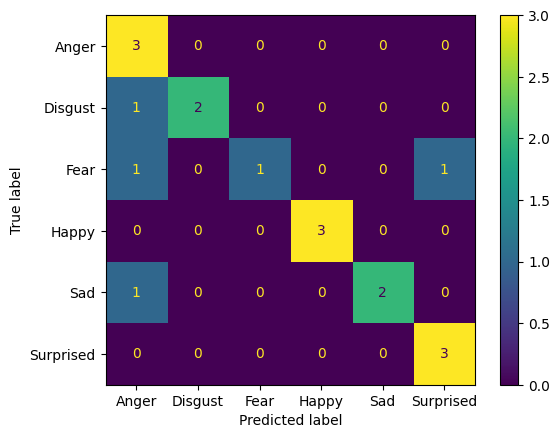

In [ ]:
# Display results
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_).plot()
plt.show()